# **<center> Colorizing black and white images using autoencoders </center>**

<center>The aim of this project is to investigate the behaviour and problems related to image colorization using autoencoders. </center>

_Authors_:
- Daniel Fynn
- Daniele Petrillo
- Roberto Formicola

---




<h2> Introduction </h2>
All digital images are coded in some color format, the most frequent being the RGB format (Red, Green, Blue). To each pixel of an image correspond three values (usually uint from 0 to 255), that represent the amount of red, green and blue color of the pixel itself, which summed together, form the color that is ultimately perceived by the human eye.

For example, this image is just...

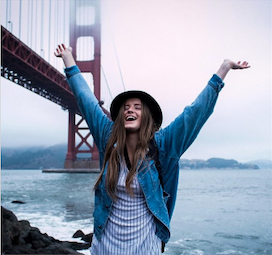

the layer of the 3 RGB channels:

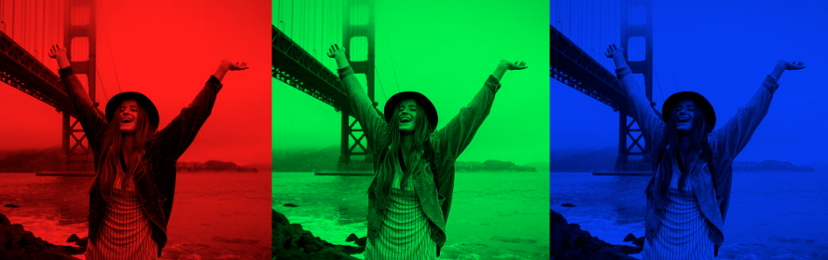

The images can then thought as <i>4-D Tensors</i> of shape (3 - 256 - 256 - 256). The data cube for each single pixel has too many degrees of freedom.

Despite the RGB format is the most common approach to color encoding, in this project we will make use of another format, called <b>LAB</b>, where L stands for Lightness, very similar to gray scale, while A and B are responsible for the colors.
The autoencoder will take as input the L (lightness scale) channel of an image and will be trained to predict the A and B channels (so the color of the image).

To better explain the LAB color space, here's the LAB version of the same image:

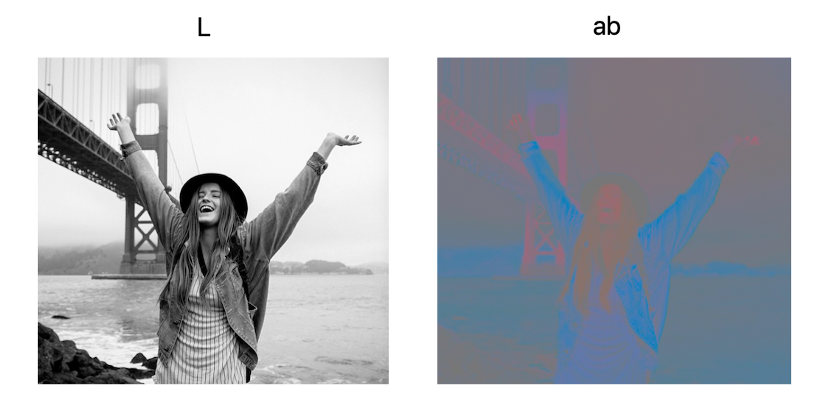

The neural network that we have used to colorize b/w images is a particular neural network called **Autoencoder**.

---

<h2> What is an AutoEncoder? </h2>

An autoencoder is a neural network that is trained to attempt to copy its input to its output, while keeping only the useful features and discarding all noise/useless informations. It is composed of two parts: the encoder, and the decoder.
The autoencoder fulcrum is the code, which can be of variable dimension: the shorter it is, the less are the latent features stored used to recreate the image.

The encoder is a NN that aims to reduce significantly the original dimension of the input, while keeping all important information; in this way it assigns to each input a correspondent internal code.

The decoder does the exact opposite, it tries to reconstruct the original input by decoding the code proposed by the encoder, with the intention to create an output as meaningfully close to the original input.

In our case, the encoder is a CNN that takes as input the Ligthness channel of the images and reduces its dimension through several Convolutional layers, while the decoder tries to predict the correspondant A and B color channels, upscaling the internal code according to the output dimension needed.

An semantic representation of an autoencoder is presented in the following picture:



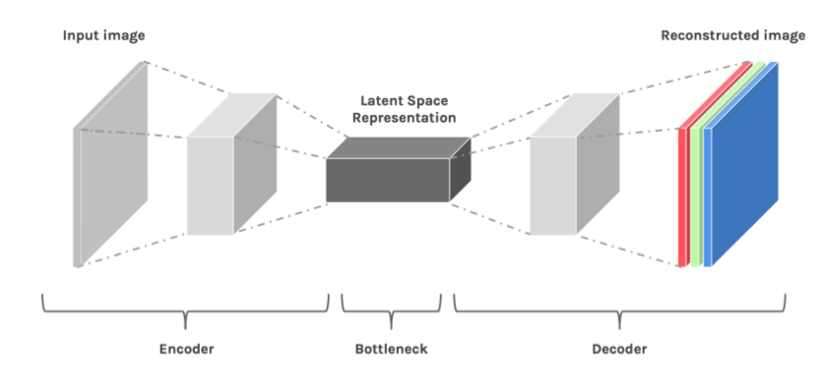

Now that we know what is an autoencoder and what does it mean to colorize black and white images we can start to work on Python.

---

<h2> Model Selection and Construction </h2>

First, we import all the necessary libraries and functions; we remind that the model will be built and trained using the library <code>Keras</code>:

In [ ]:
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img

from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
from skimage.io import imsave, imshow
from matplotlib import pyplot as plt


import numpy as np
import tensorflow as tf
import keras

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
import pandas as pd

# to use google drive as project folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Then we visualize the dataset with this cell, it shows the number of classes of the dataset in the path location; in our case class labels are not necessary, so we put all the images in the same folder named <code>1001Landscapes</code>.

![](https://github.com/robertoformi/cestino/blob/main/show.png?raw=true) <br>
<i> The images are both from natural and urban environments: hence the semantic features are not few. </i>

This particular dataset consists in 1001 images of landscapes, taken from a larger dataset from Kaggle with more than 7000 images; we limited ourselves because we noticed that Google Colab wasn't able to process more images without running out of RAM. <br>
The images are 16 KB each with size 150x150 pxs.

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks (1)/Landscapes/1001Landscapes_2"
import glob, os
os.chdir(path)

print("Classes:")
count = 1
for file in glob.glob("*"):
    print(count, file)
    count +=1

Classes:
1 1001Landscapes
2 colorise_autoencoder_landscapes300ep_2.model
3 show.png


Here we actually load the dataset into the variable train, while rescaling each image to 256 x 256, in order to create an homogenous dataset and to reduce the computational cost of the algorithm; the images are also shuffled.

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1. / 255)

#train = train_datagen.flow_from_directory(path, target_size = (256,256), batch_size = 1001, class_mode = None, classes = None, shuffle=True)
train = train_datagen.flow_from_directory(path, target_size = (150,150), batch_size = 1001, class_mode = None, classes = None, shuffle=True) # more testing needed

Found 1001 images belonging to 1 classes.


This cell is responsible for transforming the images from RGB to LAB, and also rescaling them appropriatly when saving them as numpy arrays. At the end, we can see that these arrays have the correct shape:

*   The X array represents the Lightness encoding (so 1001 images x 256x256 pixels x 1 channel)
*   The Y array represents the A and B encoding (so 1001 images x 256x256 pixels x 2 channels)



In [ ]:
X = []
Y = []

for img in train[0]:
  try:
    lab = rgb2lab(img)
    X.append(lab[:,:,0])
    Y.append(lab[:,:,1:]/128)
  except:
    print("error")

X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,))
print(X.shape)
print(Y.shape)

(1001, 256, 256, 1)
(1001, 256, 256, 2)


The following code defines the neural network structure.

One small but important detail to mention is that the last activation function needs to give as output a value between -1 and 1 (because that's the range in which the A and B normalized channels work); for this reason, we can't choose ReLU as we did for all other layers, but instead we use tanh, that does exactly what needed:

In [ ]:
SIZE = 256
model = Sequential()
model.add(Conv2D(64, (3,3), activation = "relu", padding = "same", strides = 2, input_shape = (SIZE, SIZE, 1)))
#model.add(MaxPooling2D((2,2), padding = "same"))
model.add(Conv2D(128, (3,3), activation = "relu", padding = "same"))
#model.add(MaxPooling2D((2,2), padding = "same"))
model.add(Conv2D(128, (3,3), activation = "relu", padding = "same", strides = 2))
model.add(Conv2D(256, (3,3), activation = "relu", padding = "same"))
model.add(Conv2D(256, (3,3), activation = "relu", padding = "same", strides = 2))
model.add(Conv2D(512, (3,3), activation = "relu", padding = "same"))
model.add(Conv2D(512, (3,3), activation = "relu", padding = "same"))
model.add(Conv2D(256, (3,3), activation = "relu", padding = "same"))


#model.add(MaxPooling2D((2,2), padding = "same"))

model.add(Conv2D(128, (3,3), activation = "relu", padding = "same"))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(64, (3,3), activation = "relu", padding = "same"))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(32, (3,3), activation = "relu", padding = "same"))
#model.add(UpSampling2D((2,2)))
model.add(Conv2D(16, (3,3), activation = "relu", padding = "same"))
model.add(Conv2D(2, (3,3), activation = "tanh", padding = "same"))
model.add(UpSampling2D((2,2)))

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001), loss = "mse", metrics  = ["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 256)       295168    
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 256)       590080    
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 512)       1180160   
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 512)       2

---

<h2> Model Training </h2>

The model is trained for 300 epochs, with a validation split of 10% and a batch size of 16. This work usually takes hours of time, but with google colab GPU implementation it can be done in around 45 minutes:

In [ ]:
model.fit(X,Y, epochs = 300, batch_size = 16, validation_split=0.1)

model.save("colorise_autoencoder_landscapes300ep_2.model")

Epoch 1/300
57/57 [==============================] - 23s 209ms/step - loss: 0.0117 - accuracy: 0.5742 - val_loss: 0.0137 - val_accuracy: 0.6586
Epoch 2/300
57/57 [==============================] - 9s 166ms/step - loss: 0.0105 - accuracy: 0.6241 - val_loss: 0.0146 - val_accuracy: 0.6462
Epoch 3/300
57/57 [==============================] - 9s 166ms/step - loss: 0.0104 - accuracy: 0.6337 - val_loss: 0.0135 - val_accuracy: 0.6789
Epoch 4/300
57/57 [==============================] - 9s 166ms/step - loss: 0.0103 - accuracy: 0.6405 - val_loss: 0.0132 - val_accuracy: 0.6917
Epoch 5/300
57/57 [==============================] - 9s 167ms/step - loss: 0.0101 - accuracy: 0.6417 - val_loss: 0.0128 - val_accuracy: 0.7034
Epoch 6/300
57/57 [==============================] - 10s 167ms/step - loss: 0.0099 - accuracy: 0.6471 - val_loss: 0.0126 - val_accuracy: 0.7025
Epoch 7/300
57/57 [==============================] - 9s 167ms/step - loss: 0.0099 - accuracy: 0.6472 - val_loss: 0.0122 - val_accuracy: 0.71

The autoencoder converges at around 15 epochs, then there's an almost stationary trench in accuracy.

---

<h2> Model Testing </h2>
After saving the trained model, we can use it to make prediction on images of the training set and images which the model never saw.

1/1 [==============================] - 0s 133ms/step


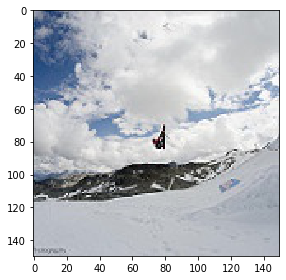

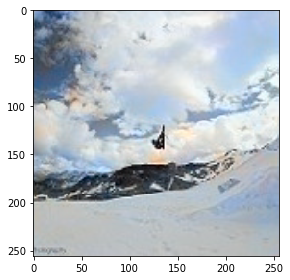

1/1 [==============================] - 0s 23ms/step


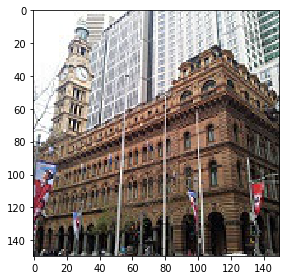

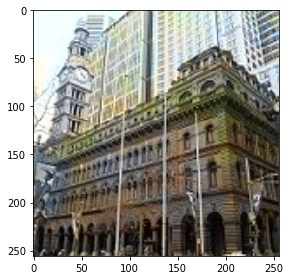

1/1 [==============================] - 0s 30ms/step


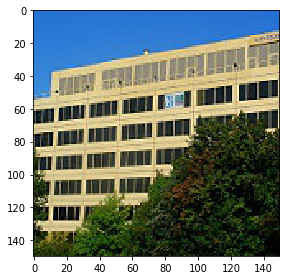

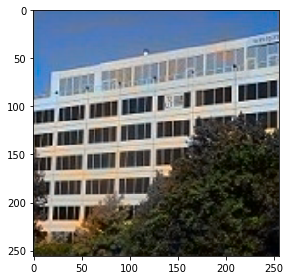

1/1 [==============================] - 0s 24ms/step


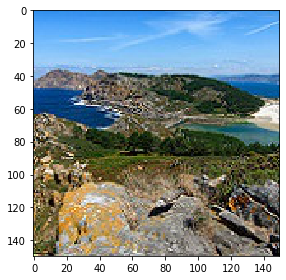

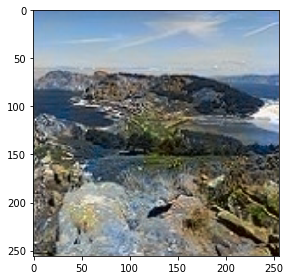

1/1 [==============================] - 0s 20ms/step


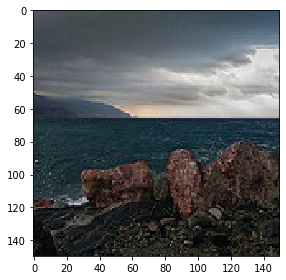

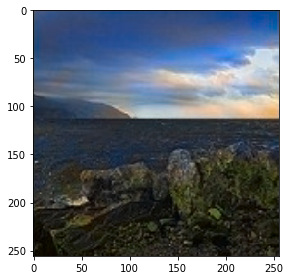

1/1 [==============================] - 0s 20ms/step


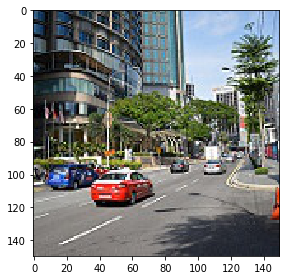

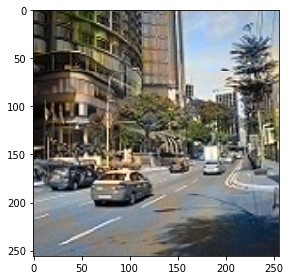

1/1 [==============================] - 0s 32ms/step


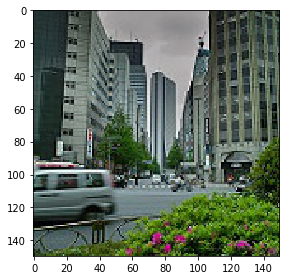

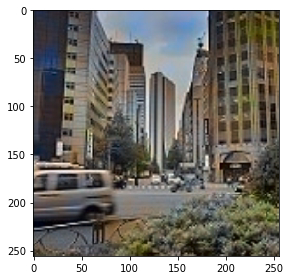

1/1 [==============================] - 0s 24ms/step


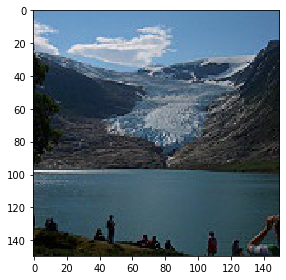

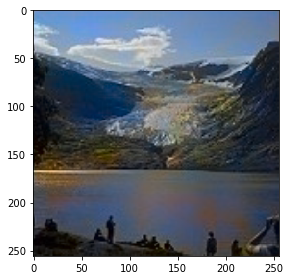

1/1 [==============================] - 0s 21ms/step


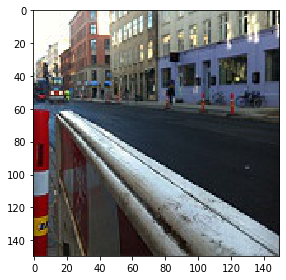

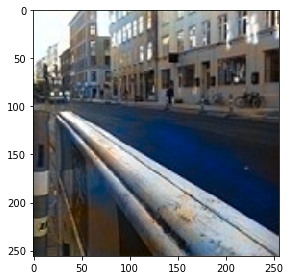

1/1 [==============================] - 0s 28ms/step


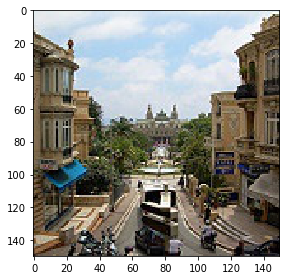

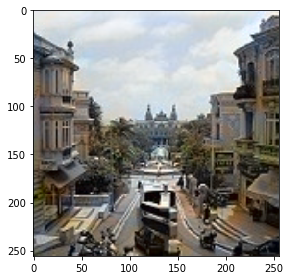

1/1 [==============================] - 0s 27ms/step


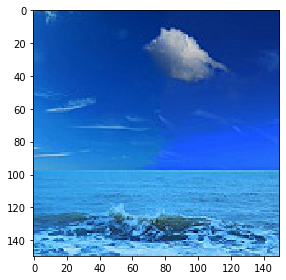

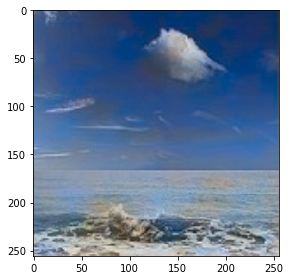

1/1 [==============================] - 0s 21ms/step


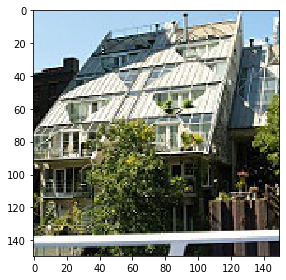

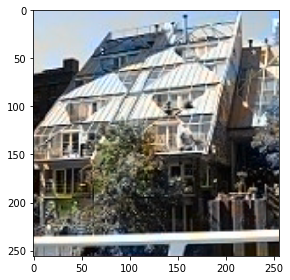

1/1 [==============================] - 0s 27ms/step


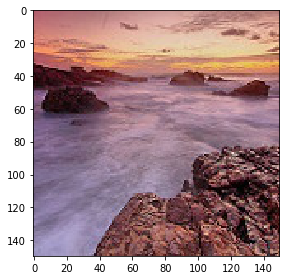

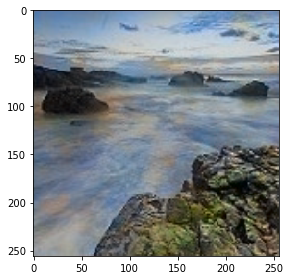

1/1 [==============================] - 0s 21ms/step


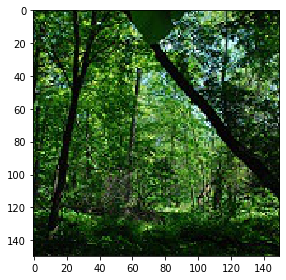

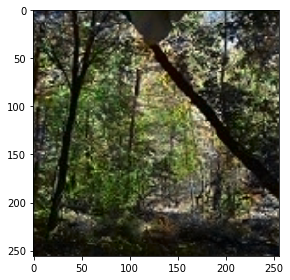

1/1 [==============================] - 0s 22ms/step


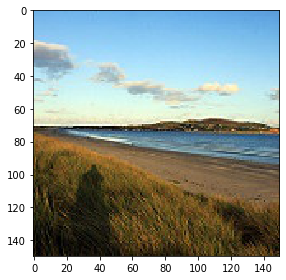

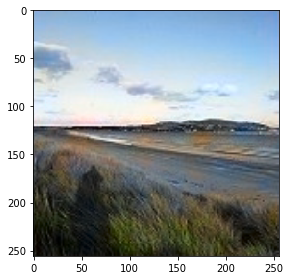

1/1 [==============================] - 0s 22ms/step


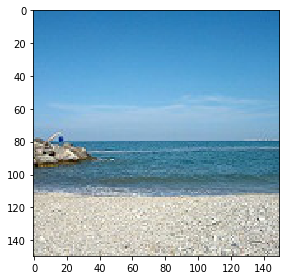

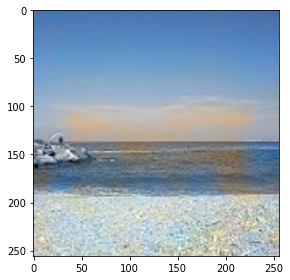

In [ ]:
#To colourise using model


model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks (1)/Landscapes/1001Landscapes_2/colorise_autoencoder_landscapes300ep_2.model",
                                   custom_objects = None,
                                   compile = True)

path = "/content/drive/MyDrive/Colab Notebooks (1)/Landscapes/Test images/"
os.chdir(path)

test_image=[]

for file in glob.glob("*"):
    test_image.append(file)



for test in test_image:

  img1_color =  []

  test_path = "/content/drive/MyDrive/Colab Notebooks (1)/Landscapes/Test images/" + test
  img1 = img_to_array(load_img(test_path))
  #img1 = img_to_array(load_img("/content/drive/MyDrive/Colab Notebooks (1)/Landscapes/Test images/6989.jpg"))


  img1 = resize(img1, (256,256))
  img1_color.append(img1)

  img1_color = np.array(img1_color, dtype = float)
  img1_color = rgb2lab(1./255 * img1_color)[:,:,:,0]
  img1_color = img1_color.reshape(img1_color.shape + (1,))

  output1=model.predict(img1_color)
  output1 = output1*128

  result = np.zeros((256,256,3))
  result[:,:,0] = img1_color[0][:,:,0]
  result[:,:,1:] = output1[0]

  imshow(test_path)
  plt.show()
  imshow(lab2rgb(result))
  plt.show()

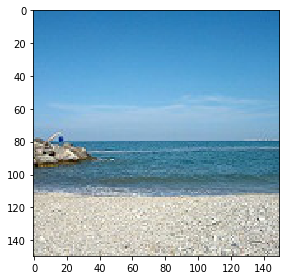

In [ ]:
#imshow("/content/drive/MyDrive/Colab Notebooks (1)/Landscapes/Test_images/6989.jpg")
imshow(test_path)

<h2> Model Assessment </h2>

---

From out test set, we take the original image...

![picture](https://github.com/robertoformi/cestino/blob/main/Seaaaa.png?raw=true)

... and compare it to our autoencoder output:

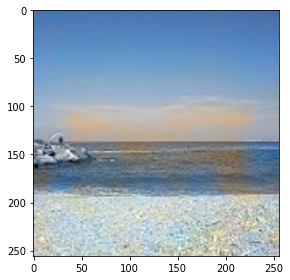

In [ ]:
imshow(lab2rgb(result))

---

<h2> Future Improvements </h2>

This first version of autoencoder seems to work fairly well in limited settings.
Sadly, performances compared to landscape have been rarely replicated in other datasets. <br>
The main bottleneck is indeed the limited computational power: in many occasions we started the model training and Google limited it, and in some cases it even abruptly stopped the training.

The autoencoder can be improved by optimizing its structure. Auto-risizing and automatic crops could be made.

We also built a web-scraper to create ad-hoc datasets: the user just needs to type a word and it just collects a fixed amount of images from Google Images.

<!-- [ADD GITHUB LINK HERE IF U WANT] -->